In [1]:
%load_ext jupyter_black

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.Linear(10, 1),
        )

    def forward(self, x):
        return self.sequential(x)


# Define a custom dataset
class DiabetesDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


# Load the Diabetes dataset
diabetes = load_diabetes()
data = diabetes.data
targets = diabetes.target

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Split the data into training and test sets
data_train, data_test, targets_train, targets_test = train_test_split(
    data, targets, test_size=0.2, random_state=42
)

# Convert data to tensors
data_train = torch.tensor(data_train, dtype=torch.float32)
targets_train = torch.tensor(targets_train, dtype=torch.float32).view(-1, 1)
data_test = torch.tensor(data_test, dtype=torch.float32)
targets_test = torch.tensor(targets_test, dtype=torch.float32).view(-1, 1)

# Create datasets
train_dataset = DiabetesDataset(data_train, targets_train)
test_dataset = DiabetesDataset(data_test, targets_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

# Initialize the model, loss function and optimizer
model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Creating a training loop

In [10]:
n_epochs = 100
losses = torch.empty(n_epochs)
val_losses = torch.empty(n_epochs)
model.to("cuda")

for epoch in range(n_epochs):
    batch_losses = torch.empty(len(train_loader))
    for i, (features, target) in enumerate(train_loader):
        model.train()
        features = features.to("cuda")
        target = target.to("cuda")

        preds = model(features)

        loss = criterion(preds, target)
        batch_losses[i] = loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
    losses[epoch] = batch_losses.mean()

    batch_val_losses = torch.empty(len(test_loader))
    with torch.inference_mode():
        for i, (features, target) in enumerate(test_loader):
            model.eval()
            features = features.to("cuda")
            target = target.to("cuda")

            preds = model(features)

            loss = criterion(preds, target)
            batch_val_losses[i] = loss.item()
    val_losses[epoch] = batch_val_losses.mean()

In [11]:
losses.shape

torch.Size([100])

In [15]:
def save_checkpoint(model, optimizer, filename):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

In [17]:
save_checkpoint(model, optimizer, "model.pth")

In [19]:
empty_model = LinearRegressionModel()
empty_optimizer = optim.Adam(empty_model.parameters(), lr=0.01)

load_checkpoint(empty_model, empty_optimizer, "model.pth")

In [22]:
# before to use
empty_model.eval()
empty_model.to("cuda")
# use

LinearRegressionModel(
  (sequential): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=10, bias=True)
    (7): Linear(in_features=10, out_features=1, bias=True)
  )
)

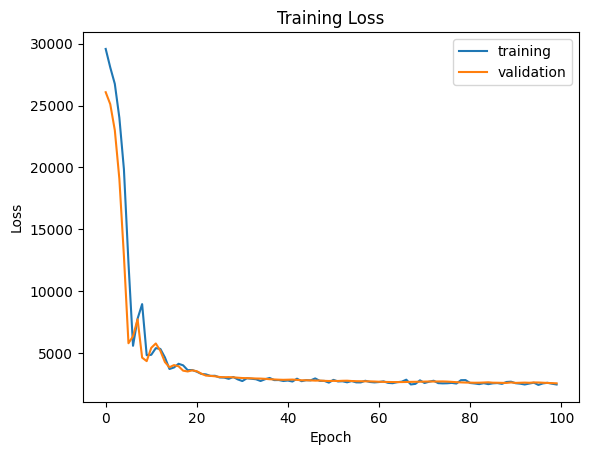

In [14]:
import matplotlib.pyplot as plt

plt.plot(losses, label="training")
plt.plot(val_losses, label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()